# SYDE 552 Assignment 1: Neuron Models
### Due Monday, January 29, 11:59pm
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with neuron models of various complexitites. To do so, we'll be using the BRIAN2 neural simulator, a Python library for creating arbitrary spiking neuron models by defining the underlying equations. We'll provide a basic tutorial for BRIAN that should include everything needed to do this assigment, but for additional help and existing neuron implmenetations, see the links below. 

Work in groups of 1-2 people. Your code should be original, but you can borrow ideas and equations from these sources when building your models (please note when you do). Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

Additional sources
 - Equations: Dayan and Abbott Ch.5-6, Gerstner et al Ch.1-2
 - BRIAN2 documentation: https://brian2.readthedocs.io/en/stable/index.html
 - Working examples: https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html, https://brian2.readthedocs.io/en/stable/user/multicompartmental.html, https://neuronaldynamics-exercises.readthedocs.io/en/latest/

# Install and Import Libraries


Install BRIAN2 (https://brian2.readthedocs.io/en/stable/introduction/install.html). You'll also need jupyter, numpy, scipy, and matplotlib. I reccomend using ```pip``` to install everything: from a terminal, run

```pip install brian2```

```pip install jupyter numpy scipy matplotlib```


open this jupyter notebook with 

```jupyter notebook syde552assigment1.ipynb```

In [1]:
import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

# Note: Ceili Minten and I worked together for some parts of the assignment, but all code submitted is individual work.

# Intro to BRIAN2 (integrate-and-fire models)
BRIAN uses a unit system to give the constants in neuron equations appropriate physical dimensions

In [2]:
v_demo = -65*mV  # voltage
print(v_demo)

-65. mV


BRIAN does unit combinations, but will tell you when units don't match up

In [3]:
r_demo = 10*ohm  # resistance
i_demo = v_demo/r_demo  # calculate current
print(i_demo)

-6.5 mA


In [4]:
v_demo + i_demo  # volts + amps = (invalid) - should produce a DimensionMismatchError

DimensionMismatchError: Cannot calculate -65. mV + -6.5 mA, units do not match (units are V and A).

Equations are written as strings, adding a ```: unit``` at the end

In [5]:
tau = 10*ms
eqn = '''dv/dt = -v/tau : mV'''

Note that ```mV``` describes the unit for the new variable ```v``` that is being defined by the equation, not the quantity on the left-hand-side (which would here be mV/s).

If you want to have the variable be unitless, you can type ```: 1```.

In [6]:
eqn = '''
dv/dt = (1-v)/tau: 1  # leak towards v_eq=1 
'''

Create a neuron by defining an "ensemble" (population) of neurons

In [7]:
ens = NeuronGroup(1, eqn, method='exact')  # n=1 neurons in the population, "exact" numerical integration

Set up a probe to record state variables from neurons in ```ens```

In [8]:
p = StateMonitor(ens, 'v', record=True)

Run the simulation

In [9]:
run(100*ms)

Plot the result

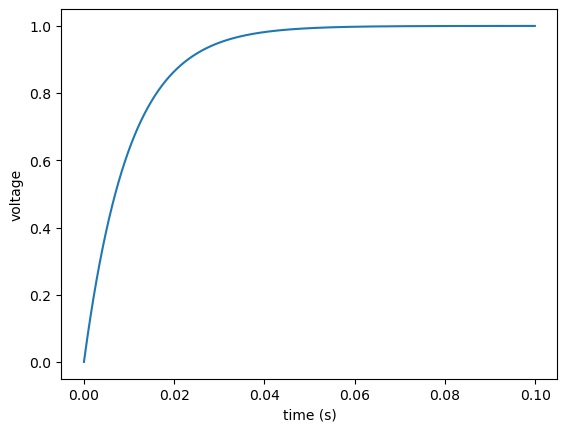

In [10]:
fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (s)', ylabel='voltage')
plt.show()

Now let's add in a spiking mechanism, which includes a "threshold" and a "reset" mechanism.

The ```threshold``` block defines the condition which must be met to register a "spike".

The ```reset``` block defines what happens when a spike occurs.

Before we start, let's explicitly create a scope for this particular model. This avoids accidentally carrying over from variables / constants defined earlier in the notebook.

In [11]:
start_scope()

tau = 10*ms
v_target = 10*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''dv/dt = (v_target - v)/tau : volt'''

ens = NeuronGroup(1, eqn, threshold='v > theta', reset='v = v_reset', method='euler')

Notice that we started using real units, and changed our numerical integration scheme to a simple numerical solver (Euler's Method)

We also need to define a new type of probe to collect spikes

In [12]:
p = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

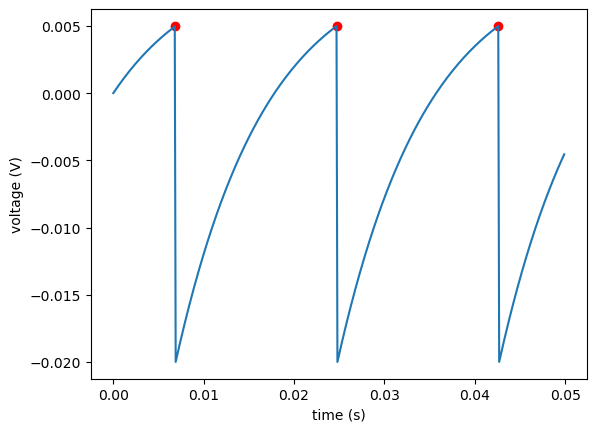

In [13]:
run(50*ms)

fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])
ax.scatter(p_s.t, theta*np.ones((len(p_s.t))), color='r')
ax.set(xlabel='time (s)', ylabel='voltage (V)')
plt.show()

Reset and refractory mechanisms can also be specified as complex expressions, each defined by its own string.

We'll add a unitless state variable ```a``` that is incremented when a spike occurs, and increases the spike threshold and the refractor period

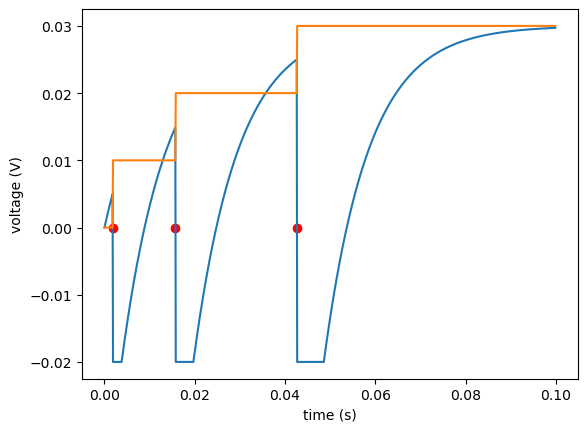

In [14]:
start_scope()

tau = 10*ms
v_target = 30*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''
dv/dt = (v_target - v)/tau : volt  (unless refractory)
a : 1  # unitless
'''

thr = '''v > theta + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''

ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='euler')

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(100*ms)

fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])
ax.plot(p_a.t, p_a.a[0])
ax.scatter(p_s.t, np.zeros((p_s.t.shape)), color='r')
ax.set(xlabel='time (s)', ylabel='voltage (V)')
plt.show()

# Question 1: LIF Neuron

## 1.1 [2 points] Implement the LIF neuron. Simulate the neuron with a 2mA external current. Plot voltage vs time.

#### Equations: 
$\frac{dV}{dt} = -\frac{1}{RC}(V - E_{leak}) + \frac{1}{C}I_{ext}$

if $V>V_{thr}$:
- set $V=V_{reset}$
- begin a refractory period of $\tau_{ref}$ ms
 
#### Constants:
 - $R = 10$ ohm
 - $C = 1$ mfarad
 - $\tau_{ref} = 2$ ms
 - $E_{leak} = -65$ mV
 - $V_{thr} = -50$ mV
 - $V_{reset} = -80$ mV
 - $I_{ext} = 2$ mA
 
#### Notes
 - set state variables using ```ens.v = v_initial```

In [2]:
# function for plotting:
def plot_voltage_trace(probe, title, xlabel='time (s)', ylabel='voltage (V)', v_thresh=-50*mV, spikes=None, plot_threshold=False, legend=True):
    fig, ax = plt.subplots()
    ax.plot(probe.t, probe.v[0], label='voltage')

    # some plotting options:
    if spikes is not None: ax.scatter(spikes.t, np.zeros(spikes.t.shape), s=20, color='r', label='spikes')
    if plot_threshold: ax.plot(probe.t, np.ones((probe.t.shape))*v_thresh, '--', color='gray', label='threshold')
    if legend is not None: ax.legend()

    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title)
    
    return fig

In [3]:
start_scope()

# define constants as above:
R = 10*ohm
C = 1*mfarad
tau_ref = 2*ms
E_leak = -65*mV
v_thresh = -50*mV
v_reset = -80*mV
I_ext = 2*mA

In [4]:
start_scope()

# define LIF neuron equations:
eqn = '''dv/dt = (-1/(R*C))*(v - E_leak) + I_ext/C : volt'''
threshold = '''v > v_thresh'''
reset = '''v = v_reset'''
refractory = '''tau_ref'''

ensemble = NeuronGroup(1, eqn, threshold=threshold, reset=reset, refractory=refractory, method='euler')
ensemble.v = E_leak # set initial voltage to resting potential
probe = StateMonitor(ensemble, 'v', record=True)
spikes = SpikeMonitor(ensemble)

run(100*ms)

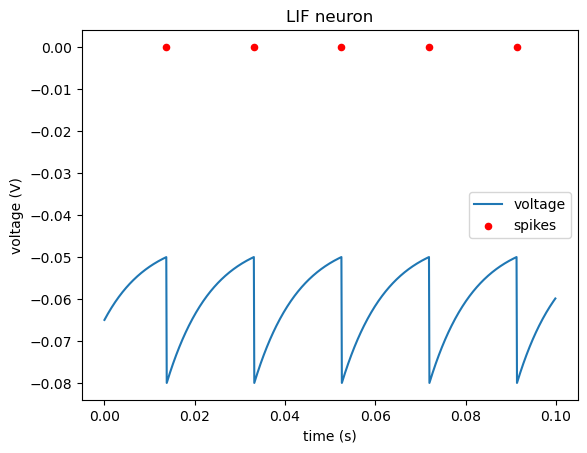

In [5]:
fig = plot_voltage_trace(probe, 'LIF neuron', spikes=spikes)

## 1.2 [2 points] Create response curves for the LIF neuron
 - (a) Inject a constant test current into the neuron, run the simulation, and count the number of spikes. Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.
 - (b) Choose a new value of R or C, run the experiment from (a) again, and add the new response curve to your plot
 - (c) Choose a new value of tau_ref, run the experiment from (a) again, and overlay the new resopnse curve to your plot

#### Parameters
- Test currents: 1-20 mA in increments of 0.5 mA
- Simulation duration: $200$ ms

### (a) Inject a constant test current into the neuron and count the number of spikes
Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.

In [6]:
def LIF_response(I, R, C=1*mfarad, tau_ref=2*ms, E_leak=-65*mV, v_thresh=-50*mV, v_reset=-80*mV, t=200*ms):
    start_scope()
    
    # LIF equations:
    eqn = '''dv/dt = -(1/(R*C))*(v - E_leak) + I/C : volt
    I : amp'''
    threshold = '''v > v_thresh'''
    reset = '''v = v_reset'''
    refractory = '''tau_ref'''

    ensemble = NeuronGroup(1, eqn, threshold=threshold, reset=reset, refractory=refractory, method='euler')
    spikes = SpikeMonitor(ensemble)
    ensemble.v = E_leak
    ensemble.I = I
    run(t)
    
    return spikes

In [7]:
test_currents = np.arange(1, 20, 0.5)*mA # 1 to 20 mA in 0.5 mA steps
firing_rates_a = np.zeros((len(test_currents)))

# for each current, run a simulation and record the spike count (keeping all other parameters constant):
for i in range(len(test_currents)):
    spikes = LIF_response(test_currents[i], 10*ohm, 1*mfarad, tau_ref, t=200*ms)
    firing_rates_a[i] = len(spikes)/(200*ms) # spikes/s

WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 1. * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 1.5 * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 2. * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 2.5 * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 3. * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 3

### (b) Choose a new value of R or C, run the experiment from (a) again
Add the new response curve to your plot

In [8]:
firing_rates_b = np.zeros((len(test_currents)))

# using a C value of 0.5 mfarad:
for i in range(len(test_currents)):
    spikes = LIF_response(test_currents[i], 10*ohm, 0.5*mfarad, tau_ref, t=200*ms)
    firing_rates_b[i] = len(spikes)/(200*ms)

### (c) Choose a new value of tau_ref
Run the experiment from (a) again, and overlay the new resopnse curve to your plot


In [9]:
firing_rates_c = np.zeros((len(test_currents)))

# using a tau_ref value of 5 ms:
for i in range(len(test_currents)):
    spikes = LIF_response(test_currents[i], 10*ohm, 1*mfarad, tau_ref=5*ms)
    firing_rates_c[i] = len(spikes)/(200*ms)


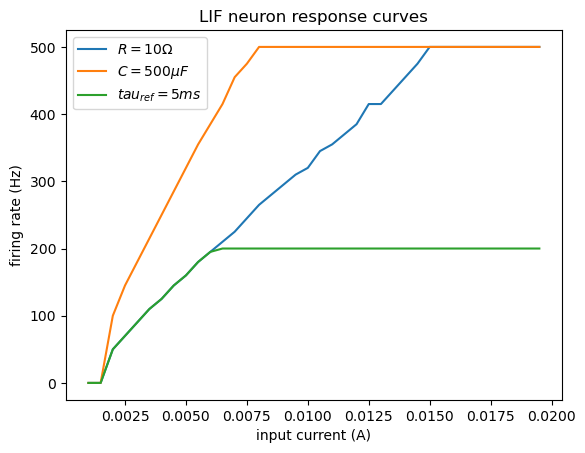

In [10]:
# plot the response curve of the neuron:
fig, ax = plt.subplots()
ax.plot(test_currents, firing_rates_a)
ax.plot(test_currents, firing_rates_b)
ax.plot(test_currents, firing_rates_c)
ax.set(xlabel='input current (A)', ylabel='firing rate (Hz)')
ax.legend(['$R=10 \\Omega$', '$C=500 \\mu F$', '$tau_{ref}=5 ms$'])
ax.set_title('LIF neuron response curves')
plt.show()

The blue trace above shows the tuning curve with default parameters: $R = 10 \Omega$, $C = 1 mF$, $\tau_{ref}=2 ms$. The orange trace shows the effect of decreasing $C$ to $0.5 mF$ – this reduces the RC time constant of the cell membrane, allowing it to reach steady-state sooner. This causes the firing rate to increase more quickly (note that the neuron saturates at the same maximum firing rate as before, just sooner). The green trace shows the effect of increasing the time constant $\tau_{ref}$. The refractory period defines the minimum time itnerval between consecutive spikes, effectively reducing the maximum firing rate of the neuron (here, 200 instead of 500 Hz). This is exactly what we would expect, since the maximum firing rate is inversely proportional to the change in $\tau$, from 2 ms to 5 ms.

## 1.3 [2 points] Add an adaptation term to the LIF neuron. Calculate the inter-spike-interval and plot it versus spike number to demonstrate adaptation.
 - Inter-spike-interval (ISI) is defined as the length of time between two spikes. To calculate it, compute the difference between the spike times returned from a BRIAN spike monitor
   - tip: use ```np.diff()```
 - Plot the resulting array of values as a scatter plot: $y$ values will be ISI in ms, and $x$ values will range from $1$ to $C$, the spike count value at the end of the simulation.

#### Additional Equations
$\frac{da}{dt} = -\frac{a}{\tau_a}$

$v_{thr} = -50mV + a$

if $v > v_{thr}$:
  - $a = a + \Delta A$
  
#### Additional Constants
- $I_{ext} = 2$ mA
- $\tau_a = 100$ ms
- $\Delta A = 1$ mV
- runtime = 500 ms

In [11]:
# add an adaptation a to the LIF neuron:
def adaptive_LIF_response(I, R, C, tau_ref=2*ms, tau_a=100*ms, E_leak=-65*mV, v_thresh=-50*mV, v_reset=-80*mV, t=500*ms):
    start_scope()
    
    # LIF equations:
    eqn = '''dv/dt = (-1/(R*C))*(v - E_leak) + I/C : volt
    da/dt = -a/tau_a : 1'''
    threshold = '''v > (v_thresh + a*volt)'''
    reset = '''v = v_reset
    a = a + 0.001''' # delta_a = 1 mV
    refractory = '''tau_ref'''

    ensemble = NeuronGroup(1, eqn, threshold=threshold, reset=reset, refractory=refractory, method='euler')
    ensemble.v = E_leak
    probe = StateMonitor(ensemble, 'v', record=True)
    spikes = SpikeMonitor(ensemble)
    run(t)
    
    return probe, spikes # spike monitor output

In [12]:
p_adaptive, spikes_adaptive = adaptive_LIF_response(2*mA, 10*ohm, 1*mfarad, tau_a=100*ms)

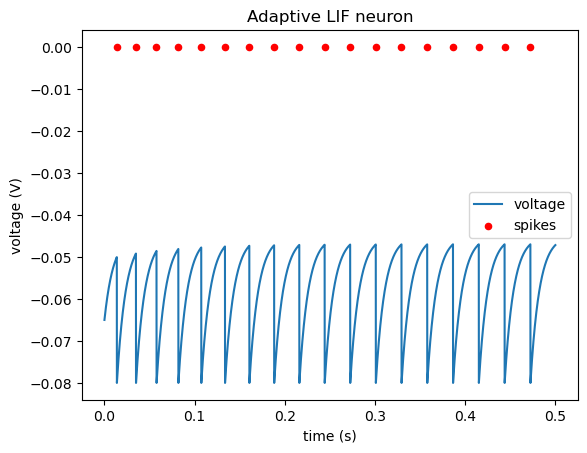

In [13]:
# plot of adaptive neuron voltage over time:
fig = plot_voltage_trace(p_adaptive, spikes=spikes_adaptive, title='Adaptive LIF neuron')

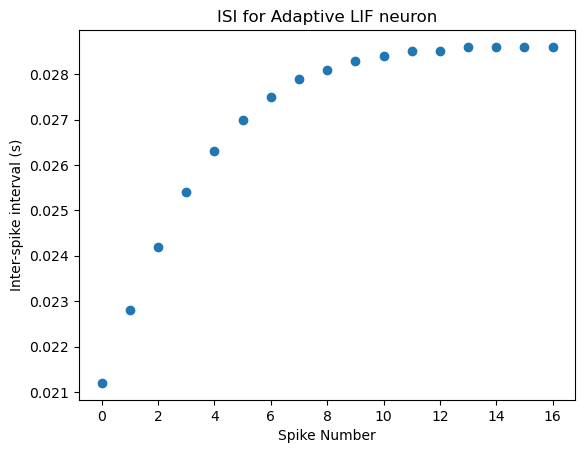

In [14]:
# plot inter-spike interval:
spike_number = np.arange(0, len(spikes_adaptive.t)-1, 1)
isi = np.diff(spikes_adaptive.t)

fig, ax = plt.subplots()
ax.scatter(spike_number, isi)
ax.set(xlabel='Spike Number', ylabel='Inter-spike interval (s)', title='ISI for Adaptive LIF neuron')
plt.show()

## [Bonus] 1.4 [1 point] Read about other extensions to the LIF model, such as quadratic- or exponential-integrate-and fire. Implement that neuron model, then
 - (a) plot the voltage trace
 - (b) plot the response curve
 - (c) plot spike adaptation

### (a) Plot voltage trace

In [15]:
def ad_ex(I_ext, t=100*ms):
    start_scope()

    # constants (from [1])
    C = 281*pF
    g_L = 30*nS
    E_l = -70.6*mV
    v_thresh = -50.4*mV
    delta_T = 2*mV
    tau_w = 144*ms
    a = 4*nS
    b = 0.0805*nA

    eqn = '''
    dv/dt = (-g_L*(v - E_l) + g_L*delta_T*exp((v - v_thresh)/delta_T) - w + I)/C : volt
    dw/dt = (a*(v - E_l) - w)/tau_w : amp
    I : amp
    '''

    threshold = '''v > v_thresh'''
    reset = '''v = v_reset
    w += b'''
    refractory = '''tau'''

    ensemble = NeuronGroup(1, eqn, threshold=threshold, reset=reset, refractory=refractory, method='exponential_euler')
    defaultclock.dt = 0.01*ms
    ensemble.v = E_l
    ensemble.I = I_ext

    probe = StateMonitor(ensemble, 'v', record=True)
    spikes = SpikeMonitor(ensemble)
    run(t)
    
    return probe, spikes

In [16]:
# simulate adaptive exponential integrate and fire neuron:
p, s = ad_ex(1*nA, t=500*ms)

# plot:
fig = plot_voltage_trace(p, spikes=s, title='Adaptive Exponential (AdEx) Integrate and Fire Neuron')

BrianObjectException: Error encountered with object named 'neurongroup_3_stateupdater'.
Object was created here (most recent call only, full details in debug log):
  File '/var/folders/rx/5_fd7v5s5dbc3yr3cx7bw9m40000gn/T/ipykernel_74631/2794447566.py', line 25, in ad_ex
    ensemble = NeuronGroup(1, eqn, threshold=threshold, reset=reset, refractory=refractory, method='exponential_euler')

An error occurred when preparing an object. (See above for original error message and traceback.)

References:

[1] R. Brette and W. Gerstner, "Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity," _Journal of Neurophysiology_, vol. 94, no.5, pp. 3647-3642, Nov. 2005. doi:10.1152/jn.00686.2005.

[2] W. Gerstner, W. M. Kistler, R. Naud, and L. Paninski, "Adaptive Integrate-and-Fire Model," in _Neuronal dynamics: From single neurons to networks and models of cognition._ Cambridge: Cambridge University Press, 2014, ch. 6.1. Accessed: Jan. 28, 2024. [Online]. Available: https://neuronaldynamics.epfl.ch/index.html.

[3] "Example: Brette_Gerstner_2005," _brian2 documentation page._ [Online]. Accessed January 26, 2024. Available: https://brian2.readthedocs.io/en/stable/examples/frompapers.Brette_Gerstner_2005.html?highlight=exponential%20integrate%20and%20fire%20example#example-brette-gerstner-2005.

### (b) Plot tuning curve

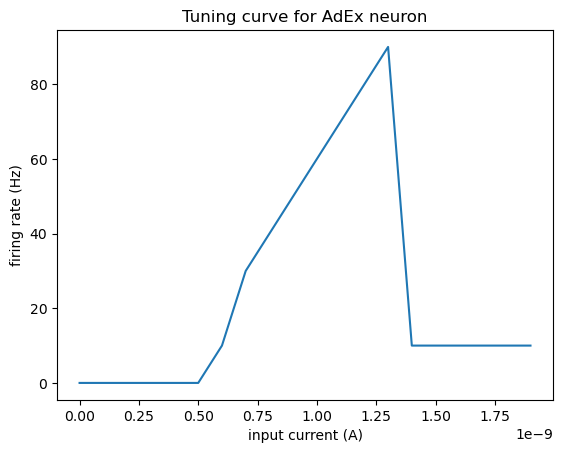

In [ ]:
# repeat experiment from Q1.2 for the exponential integrate and fire neuron:
test_currents = np.arange(0, 2, 0.1)*nA
exp_firing_rates = np.zeros((len(test_currents)))

for i in range(len(test_currents)):
    probe, spikes = ad_ex(test_currents[i], t=100*ms)
    exp_firing_rates[i] = len(spikes)/(100*ms)

# plot tuning curve:
fig, ax = plt.subplots()
ax.plot(test_currents, exp_firing_rates)
ax.set(xlabel='input current (A)', ylabel='firing rate (Hz)')
ax.set_title('Tuning curve for AdEx neuron')
plt.show()

Note: this model can account for a number of complex behaviours exhibited by neurons, such as bursting, fast spiking, etc. depending on the stimulus range [1]. These 'adaptations' are not representative of a typical spiking rate, since each range corresponds to an entirely different behaviour (unlike the the standard LIF neuron from Q1.2.). This variation will affect the firing rate that is measured, and this is why the tuning curve looks a little odd.

### (c) Plot spike adaptation

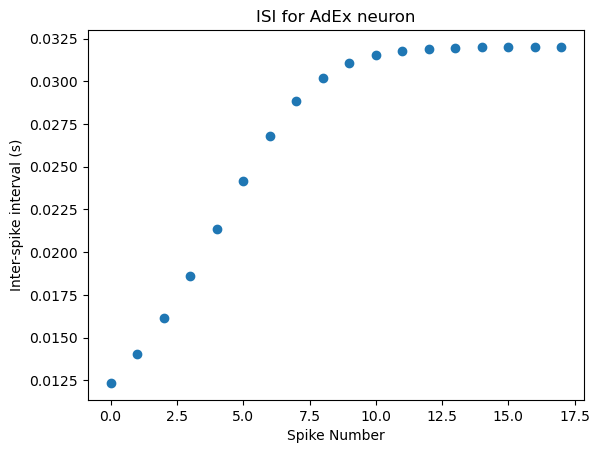

In [ ]:
# plot inter-spike interval vs. spike number to show adaptation:
spike_number = np.arange(0, len(s.t)-1, 1)
isi = np.diff(s.t)

fig, ax = plt.subplots()
ax.scatter(spike_number, isi)
ax.set(xlabel='Spike Number', ylabel='Inter-spike interval (s)', title='ISI for AdEx neuron')
plt.show()

This adaptation is qualitatively similar to the adaptation seen with the LIF neuron, with the small difference that this plot is slightly concave-up for the first few spikes (sigmoid-like shape).

# Question 2: Wilson Neuron
In his 1999 paper "Simplified dynamics of human and mammalian neocortical neurons", Wilson reduced the Hodgkin-Huxley model down to three coupled differential equations. He showed that this neuron model reproduced action potential dynamics and other electrophysiological measures without any artificial reset mechanisms.

- $\tau_v \frac{dv}{dt} = -(17.81 + 47.58v + 33.80v^2)(v - 0.48) - 26r(v + 0.95) - 13h(v + 0.95) + I_{ext}$
- $\tau_r \frac{dr}{dt} = -r + 1.29v + 0.79 + 3.30(V + 0.38)^2$
- $\tau_h \frac{dh}{dt} = -h + 11(v + 0.754)*(v + 0.69)$

where $v$ is voltage, $r$ is a recovery variable, and $h$ is a conductance variable.

- $\tau_v = 0.97$ ms
- $\tau_r = 5.6$ ms
- $\tau_H = 99.0$ ms
- $dt = 0.05$ ms

## 2.1 [2 points] Implement the Wilson Neuron.  Produce an action potential by injecting an external current (I=3 for 0.1ms). Plot voltage vs time. How does the shape of the action potential compare to observed electrophysiology?

#### Tips:
 - Units are weirdly defined in this model: ```v``` varies between $-0.9$ and $0.3$, and time constants are given in seconds. It's easiest to just make the state variables unitless (e.g.```dv/dt = ... : 1```)
 - set the simulation timestep using ```defaultclock.dt = 0.025*ms```
 - set initial conditions to keep the neuron from firing a transient spike at simulation startup:
  - $v_0=-0.75$
  - $r_0=0.2$
 - use ```v**2``` to write powers in an ```eqn=''' ... '''``` block, not ```v^2```
 - run the simulation long enough to observe the full recovery period

In [ ]:
# parameters:
tau_v = 0.97*ms
tau_r = 5.6*ms
tau_h = 99.0*ms
dt = 0.05*ms
I_ext = 3 # mA

In [ ]:
def wilson_neuron(I_ext, tau_v, tau_r, tau_h, t=10*ms, dt=0.05*ms, sustain=False):
    start_scope()

    eqn = '''
    dv/dt = (-(17.81 + 47.58*v + 33.80*v**2)*(v - 0.48) - 26*r*(v + 0.95) - 13*h*(v + 0.95) + I)/tau_v : 1
    dr/dt = (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)**2)/tau_r : 1
    dh/dt = (-h + 11*(v + 0.754)*(v + 0.69))/tau_h : 1
    I : 1'''

    wilson = NeuronGroup(1, eqn, method='euler')
    
    # set initial conditions:
    wilson.v = -0.75
    wilson.r = 0.2
    defaultclock.dt = dt
    probe = StateMonitor(wilson, 'v', record=True)

    if sustain:
        wilson.I = I_ext
        run(t)
    else:
        wilson.I = I_ext
        run(0.1*ms) # inject I_ext for 0.1 ms
        wilson.I = 0
        run(t)

    return wilson, probe

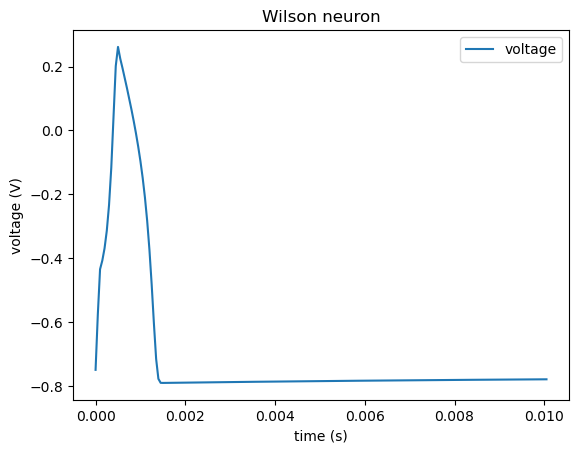

In [ ]:
# simulate a Wilson neuron:
wilson, probe = wilson_neuron(I_ext, tau_v, tau_r, tau_h, sustain=False)

# plot Wilson neuron voltage over time:
fig = plot_voltage_trace(probe, title='Wilson neuron')
    # note that the y-axis unit is arbitrary because the equations are dimensionless

The action potential observed from electrophysiological recordings is slightly rounded at the peak, with a more pronounced hyperpolarization before returning to the resing potential. In addition, there is a slight discontinuity when the spike threshold is reached, which is not seen in the biological case. The other main difference is that real action potentials tend to be more symmetrical around the peak, whereas the peak seen in this model slopes slightly to the left.

## 2.2 [1 point] Coupled ODEs in complex neuron models are numerically sensitive, and the system can explode under certain conditions. Show that increasing the timestep or injecting a powerful, sustained current produces unrealistic voltage traces.

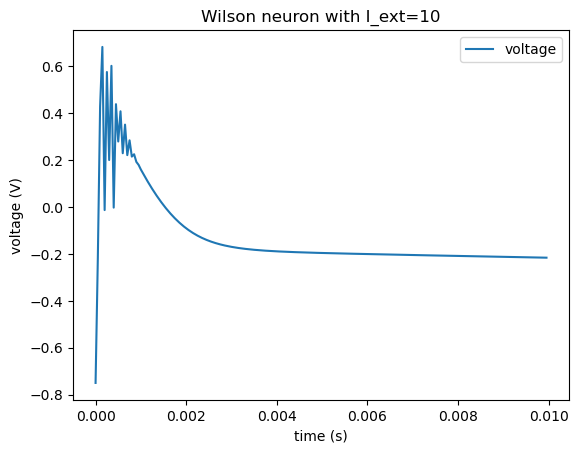

In [ ]:
# try injecting a sustained current of 10:
wilson2, probe = wilson_neuron(10, tau_v, tau_r, tau_h, t=10*ms, sustain=True)
fig = plot_voltage_trace(probe, title='Wilson neuron with I_ext=10')

# result: odd spike pattern early in the simulation, which tapers off then stops spiking completely

WARNING    neurongroup_7's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_7's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_7's variable 'r' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


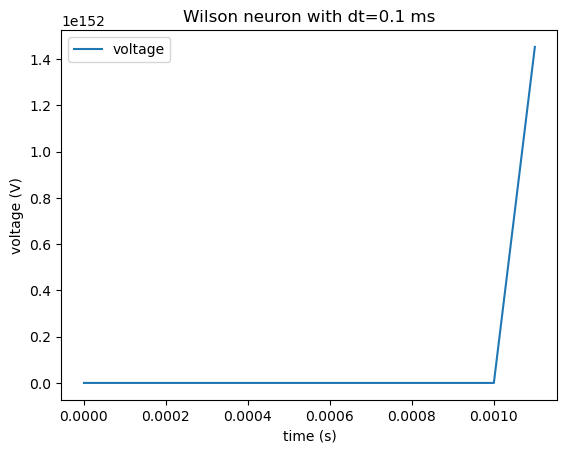

In [ ]:
# try doubling the timestep to 0.1 ms:
wilson3, probe = wilson_neuron(I_ext, tau_v, tau_r, tau_h, dt=0.1*ms, sustain=True)
fig = plot_voltage_trace(probe, title='Wilson neuron with dt=0.1 ms')

# result: incorrect integration leading to unstable output that blows up

## 2.3 [1 point] Show the Wilson neuron exhibits spike adaptation by plotting ISI versus spike number. How does this adaptation compare to the adaptive LIF neuron from Question 1.3?

#### Note
- you will need to think of a good way to define a "spike" for continuous voltages

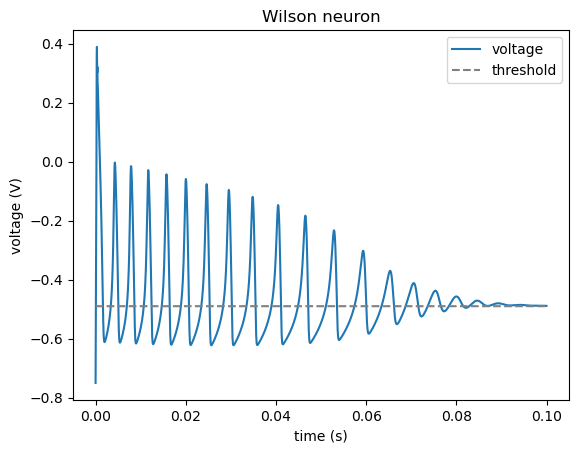

In [ ]:
# inject an external current of 3 over 100 ms to observe spiking pattern:
wilson, probe = wilson_neuron(I_ext, tau_v, tau_r, tau_h, t=100*ms, sustain=True)

# plot the spike train:
fig = plot_voltage_trace(probe, title='Wilson neuron', v_thresh=-0.49, plot_threshold=True)

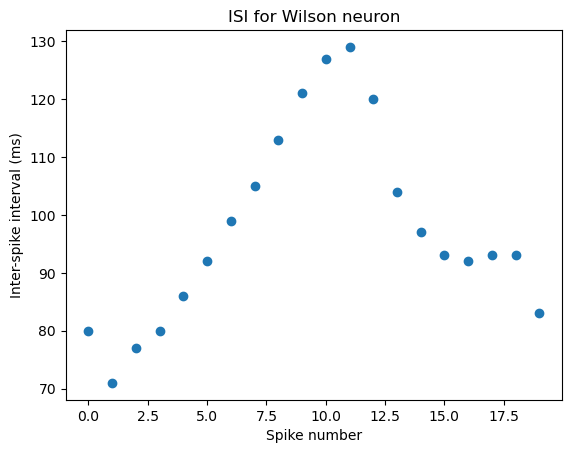

In [ ]:
spikes, _ = scipy.signal.find_peaks(probe.v[0], height=-0.49, width=5) # find peaks in voltage trace (i.e. spikes)
# print(spikes) # index of each spike
spike_number = np.arange(0, len(spikes)-1, 1) # x-axis for spike number
isi = np.diff(spikes) # calculate inter-spike interval

# plot inter-spike interval vs. spike number, using the steady-state voltage as the threshold:
fig, ax = plt.subplots()
ax.scatter(spike_number, isi) # plot
ax.set(xlabel='Spike number', ylabel='Inter-spike interval (ms)', title='ISI for Wilson neuron')
plt.show()

In this adaptation, the inter-spike interval appears to grow linearly, increasing at a steady rate over time. From the voltage trace, we can see that beyond about spike 10, the ISI starts to decrease, and so does the spike magnitude. Therefore, it would probably be useful to set a spike threshold to exclude these (see plot below), as the spikes beyond this point become less and less meaningful.

In contrast to the Wilson neuron, the adaptation of the adaptive LIF neuron from Q1.3 followed an exponential curve, eventually reaching some maximum ISI, at which point it would to continue to fire at that rate (even for larger stimuli). The spikes of the LIF neuron remained at the same height for a sustained input current, unlike what is seen here.

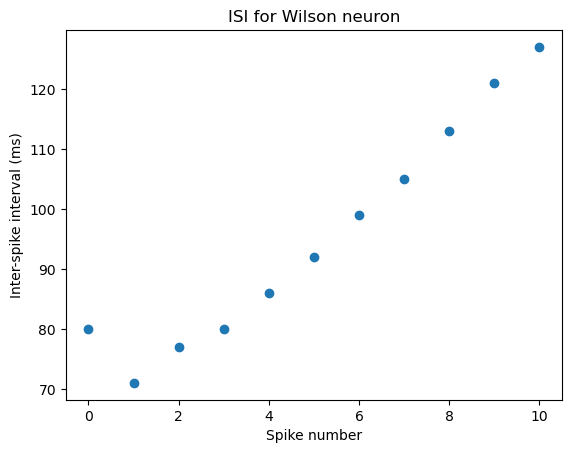

In [ ]:
spikes, _ = scipy.signal.find_peaks(probe.v[0], height=-0.3, width=5) # this time, set a threshold of -0.3 to exclude spikes below this magnitude
spike_number = np.arange(0, len(spikes)-1, 1) # x-axis for spike number
isi = np.diff(spikes) # calculate inter-spike interval

# plot inter-spike interval vs. spike number, using a higher threshold of -0.3:
fig, ax = plt.subplots()
ax.scatter(spike_number, isi) # plot
ax.set(xlabel='Spike number', ylabel='Inter-spike interval (ms)', title='ISI for Wilson neuron')
plt.show()

# Intro to BRIAN2 (compartmental models)

BRIAN2 also support multicompartment models (https://brian2.readthedocs.io/en/stable/user/multicompartmental.html).  In addition to defining the equations governing the membrane dynamics (i.e. ion channels), building a compartmental neuron requires specifying a morphology. To do this, we'll use BRIAN2's pre-built sections

In [ ]:
soma = Soma(diameter=30*um)  # defines a sphere

Attach new sections to a previously defined section like so

In [ ]:
soma.axon = Cylinder(length=100*um, diameter=1*um, n=10)  # n=10 compartments in this section
soma.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)
soma.dendrite.branch1 = Cylinder(length=10*um, diameter=1*um, n=3)
soma.dendrite.branch2 = Cylinder(length=10*um, diameter=1*um, n=3)

Now we can define a SpatialNeuron according to our biophysical equations. BRIAN will automatically solve the cable equation between all the compartments, so specifying $\frac{dv}{dt}$ and $\frac{d^2v}{dx^2}$ is unnecessary: the user only needs to define the transmembrane and external currents. Notice that physical constants and state variables are now defined relative to space.

In [ ]:
gL = 1e-4*siemens/cm**2  # leak conductance
Cm = 1*uF/cm**2  # membrane capacitance
Ri = 100*ohm*cm  # longitudinal (intracellular) resistivity
EL = -70*mV  # leak reversal potential

eqn = '''
Im = gL * (EL - v) : amp/meter**2  # total ionic (membrance) current
I : amp (point current)  # external current
# dv/dt, d2v/dx2, and I_long are calculated automatically
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri)

Set the membrane voltage of all compartments to -65mV, then apply an external current a few specific compartments. Note the use of ```.main``` to target a specific compartment

In [ ]:
neuron.v = EL + 10*mV  # applies to state variables in soma compartment AND all connected compartments
neuron.main.v = EL + 10*mV  # applies to state variables in soma compartment
neuron.main.I[0] = 1*nA  # applies only to soma
neuron.dendrite.I[3] = 0.5*nA  # applies to a compartment part way down the dendrite
neuron.dendrite.branch1.I[1] = 0.5*nA

To detect spikes, we'll add a threshold condition. To ensure that multiple spikes don't get registered if this condition remains true for a while (e.g. v>v_thr), we'll also specify a refractory condition.

In [ ]:
neuron = SpatialNeuron(morphology=soma, model=eqn,
    threshold='v > 0*mV',
    threshold_location=neuron.main[0],
    refractory='v > 0*mV',
    method="exponential_euler")

# Question 3: Hodgkin Huxley Neurons

A template for the Hodgkin-Huxley model is provided below, including various physical constants and a simple morphology. Note that voltage has been rescaled to $v_{rest} = 0$ mV, and the equations for the gating variables have shifted accordingly.

## 3.1 [2 points] Implement the Hodgkin-Huxley model by filling in the provided template. Plot voltage vs time and $m$, $n$, and $h$ versus time for an external input of ```1uA``` applied over ```3ms```. 

In [ ]:
def hodgkin_huxley_neuron(
        morpho,
        durations,
        currents,
        C_m = 1*uF/cm**2,
        R_l = 35.4*ohm*cm,
        gating_vars=True,
        location=None):
    
    start_scope()
    # constants
    E_leak = 10.613*mV
    E_na = 115*mV
    E_k = -12*mV
    g_leak = 0.3*msiemens/cm**2
    g_na = 120*msiemens/cm**2
    g_k = 36*msiemens/cm**2

    # Fill in these equations
    eqn = '''
    Im = - (g_na * m**3 * h)*(v - E_na) - (g_k * n**4)*(v - E_k) - g_leak * (v - E_leak) : amp/meter**2
    dm/dt = alpha_m*(1 - m) - beta_m*m : 1
    dn/dt = alpha_n*(1 - n) - beta_n*n : 1
    dh/dt = alpha_h*(1 - h) - beta_h*h : 1

    alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
    beta_m = 4 * exp(-v/(18*mV))/ms : Hz
    alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
    beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
    alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
    beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
    I : amp (point current) # applied external current
    '''

    defaultclock.dt = 0.01*ms
    neuron = SpatialNeuron(morphology=morpho, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

    probe_v = StateMonitor(neuron, 'v', record=True)
    probe_m = StateMonitor(neuron, 'm', record=True)
    probe_n = StateMonitor(neuron, 'n', record=True)
    probe_h = StateMonitor(neuron, 'h', record=True)

    neuron.v = 0*mV
    neuron.h = 0.6
    neuron.m = 0.1
    neuron.n = 0.3
    
    # for Q3.1/3.2, specify durations and currents to inject (assumed at location [0]):
    if location is None:
        for duration, current in zip(durations, currents):
            neuron.I[0] = current # inject a current
            run(duration) # run for specified duration

    # for Q3.4, in addition to durations and currents, specify the location along the dendrite to inject current:
    else:
        for duration, current in zip(durations, currents):
            neuron.I[location] = current
            run(duration)

    # for Q3.1, to plot m, n, h over time:
    if gating_vars:
        return probe_v, probe_m, probe_n, probe_h
    
    return probe_v

In [ ]:
# default morphology to use:
cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

# specify durations and currents (10s off, 3s at 1*uA, then 10s off):
durations = [10, 3, 10]*ms
currents = [0, 1, 0]*uA

# simulate a Hodgkin-Huxley neuron:
probe_v, probe_m, probe_n, probe_h = hodgkin_huxley_neuron(cable, durations=durations, currents=currents)

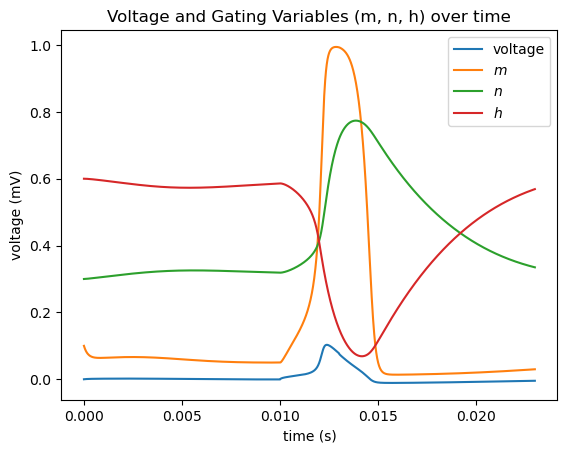

In [ ]:
# plots v, m, n, h over time:
fig, ax = plt.subplots()
ax.plot(probe_v.t, probe_v.v[0], label='voltage')
ax.plot(probe_m.t, probe_m.m[0], label='$m$')
ax.plot(probe_n.t, probe_n.n[0], label='$n$')
ax.plot(probe_h.t, probe_h.h[0], label='$h$')
ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Voltage and Gating Variables (m, n, h) over time')
ax.legend()
plt.show()

## 3.2 [0.5 point] Show that the action potential propagates down the cable with minimal attenuation.
- (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.
- (b) increase the longitudinal resistance and show that the signal propagates slower. 

### (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.


In [ ]:
# run the simulation again, but for longer, to see more of the recovery to resting potential:
durations = [10, 3, 20]*ms
currents = [0, 1, 0]*uA
probe_v = hodgkin_huxley_neuron(cable, durations=durations, currents=currents, gating_vars=False)

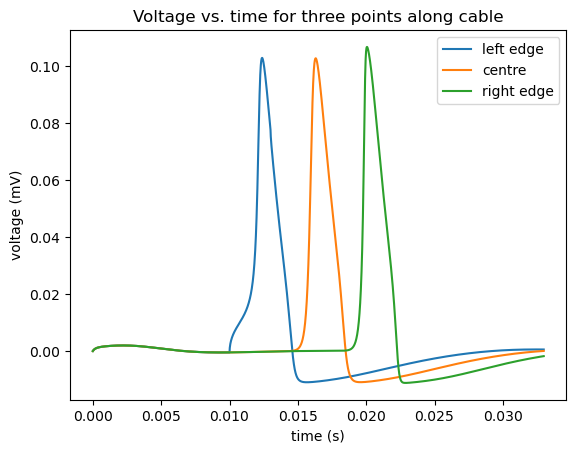

In [ ]:
fig, ax = plt.subplots()
ax.plot(probe_v.t, probe_v.v[0], label='left edge') # voltage at left edge of axon
ax.plot(probe_v.t, probe_v.v[round(probe_v.v.shape[0]/2)], label='centre') # voltage at centre of axon
ax.plot(probe_v.t, probe_v.v[-1], label='right edge') # voltage at right edge of axon
ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Voltage vs. time for three points along cable')
ax.legend()
plt.show()

In [ ]:
# show that the voltage at each measured point is nearly the same at the peak:
left_max = max(probe_v.v[0])
print("Left max: ", left_max)
centre_max = max(probe_v.v[round(probe_v.v.shape[0]/2)])
print("Centre max: ", centre_max)
right_max = max(probe_v.v[-1])
print("Right max: ", right_max)

Left max:  103.01423355 mV
Centre max:  102.87575323 mV
Right max:  106.87074973 mV


In the plot above, the action potential propagates along the axon with minimal attenuation shown by each peak having approximately the same height and shape. The maximum values are all within the range of 102-107 mV.

### (b) increase the longitudinal resistance and show that the signal propagates slower. 

In [ ]:
# increase the longitudinal resistance R_l by a factor of 3 (compared to the default value):
R_l = 70.8*ohm*cm
v = hodgkin_huxley_neuron(cable, durations, currents, R_l=R_l, gating_vars=False) # simulate

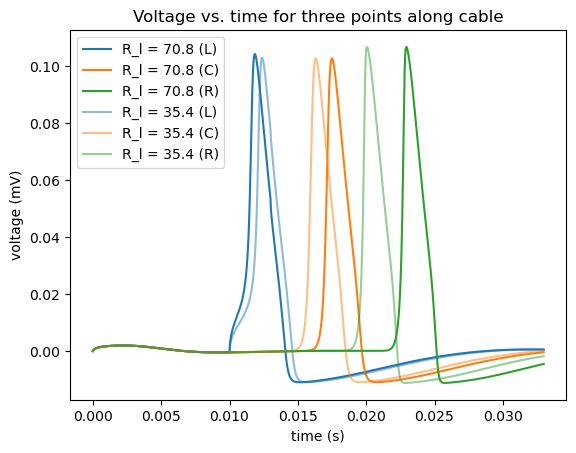

In [ ]:
fig, ax = plt.subplots()

# plot the voltage at left, right, and center with the increased R_l:
ax.plot(v.t, v.v[0], label='R_l = 70.8 (L)') # voltage at left edge of axon
ax.plot(v.t, v.v[round(v.v.shape[0]/2)], label='R_l = 70.8 (C)') # voltage at centre of axon
ax.plot(v.t, v.v[-1], label='R_l = 70.8 (R)') # voltage at right edge of axon

plt.gca().set_prop_cycle(None)

# also plot the voltage at left, right, and center with the default R_l for visual comparison:
ax.plot(probe_v.t, probe_v.v[0], label='R_l = 35.4 (L)', alpha=0.5) # voltage at left edge of axon
ax.plot(probe_v.t, probe_v.v[round(probe_v.v.shape[0]/2)], label='R_l = 35.4 (C)', alpha=0.5) # voltage at centre of axon
ax.plot(probe_v.t, probe_v.v[-1], label='R_l = 35.4 (R)', alpha=0.5) # voltage at right edge of axon

ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Voltage vs. time for three points along cable')
ax.legend()
plt.show()

In the plot above, we can see that the spikes corresponding with the action potentials at each of the three points (left, centre, right) are much more spread out in time. The centre/right spikes are delayed when the resistance is increased to $70.8 \Omega cm$, as the signal propagates more slowly.

Interestingly, the leftmost spike actually happens earlier when the resistance is increased—

## 3.3 [0.5 point] Create a stimulus that produces a rebound spike, and plot the resulting voltage trace

In [ ]:
# define arrays of input currents and time segments over which to stimulate the neuron:
c = [0, 0.4, -1, 0.4, -1, 0.4]*uA
d = [50, 50, 50, 50, 50, 50]*ms

# simulate:
v = hodgkin_huxley_neuron(cable, d, c, gating_vars=False)

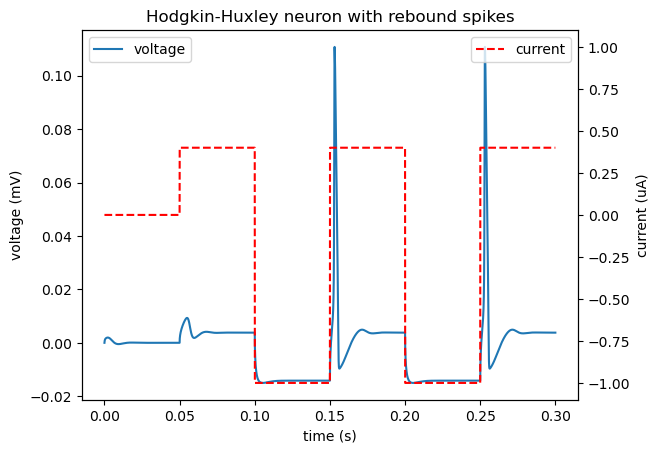

In [ ]:
# generate an array of current values to plot:
cur = np.zeros(len(v.t))
cur[5000:10000] = 0.4
cur[10000:15000] = -1
cur[15000:20000] = 0.4
cur[20000:25000] = -1
cur[25000:30000] = 0.4

# plot voltage and current on the same x-axis:
fig, ax1 = plt.subplots()
ax1.plot(v.t, v.v[0], label='voltage')
ax1.set(xlabel='time (s)', ylabel='voltage (mV)', title='Hodgkin-Huxley neuron with rebound spikes')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(v.t, cur, 'r--', label='current')
ax2.set(xlabel='time (s)', ylabel='current (uA)')
ax2.set_ylim([-1.1, 1.1])
ax2.legend()
plt.show()

Rebound spikes are generated by recovery from an inhibitory (negative) step input, but where the stimulus magnitude remains below the threshold of activation. In the plot above, we see that the stimulus current (0.4 uA) remains below the threshold because a single spike is generated after each step (rather than a repeated spiking pattern).

Reference:

[4] W. Gerstner, W. M. Kistler, R. Naud, and L. Paninski, "The Zoo of Ion Channels," in _Neuronal dynamics: From single neurons to networks and models of cognition._ Cambridge: Cambridge University Press, 2014, ch. 2.3. [Online]. Accessed: Jan. 26, 2024. Available: https://neuronaldynamics.epfl.ch/index.html.

## 3.4 [2 points] Create a new cell morphology that includes a soma and a dendritic tree with one branch. Show that voltage attenuation increases with the distance from the soma.
- Use ```Cylinder()``` for dendritic sections, with geometric parameters in these ranges:
 - ```length=10-100um```
 - ```diameter=0.1-1um```
 - ```n=5-100```
- Choose several points along the tree as injection sites.
- For each site, apply an identical external current ```I=100*pA``` and measure the resulting voltage change at the soma ($\Delta v = v_{rest} - v_{max}$).
- Plot $\Delta v$ vs distance. How does attenuation vary within a section and between sections (especially at branch points)?

In [ ]:
# create a new morphology with one branch point:
soma = Soma(diameter=30*um)
soma.d1 = Cylinder(length=50*um, diameter=0.7*um, n=100, type='dendrite')
soma.d1.d2 = Cylinder(length=20*um, diameter=0.2*um, n=50)
soma.d1.d3 = Cylinder(length=30*um, diameter=0.5*um, n=50)

In [ ]:
# select some injection sites along the dendrites:
locs = [soma.d1[0], # soma-dendrite junction
        soma.d1[49], # halfway along the major dendrite
        soma.d1.d2[0], # branch point of the dendrite
        
        soma.d1.d2[1], # first segment of the second dendrite
        soma.d1.d2[24], # halfway along the second dendrite
        soma.d1.d2[49], # end of the second dendrite

        soma.d1.d3[1], # first segment of the third dendrite
        soma.d1.d3[24], # halfway along the third dendrite
        soma.d1.d3[49]] # end of the third dendrite

In [ ]:
# for each location, inject a current of 100 pA:
durations = [20, 1, 20]*ms
currents = [0, 100, 0]*pA

# and measure the voltage change at the soma:
v1 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[0], gating_vars=False)
v2 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[1], gating_vars=False)
v3 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[2], gating_vars=False)
v4 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[3], gating_vars=False)
v5 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[4], gating_vars=False)
v6 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[5], gating_vars=False)
v7 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[6], gating_vars=False)
v8 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[7], gating_vars=False)
v9 = hodgkin_huxley_neuron(soma, durations, currents, location=locs[8], gating_vars=False)

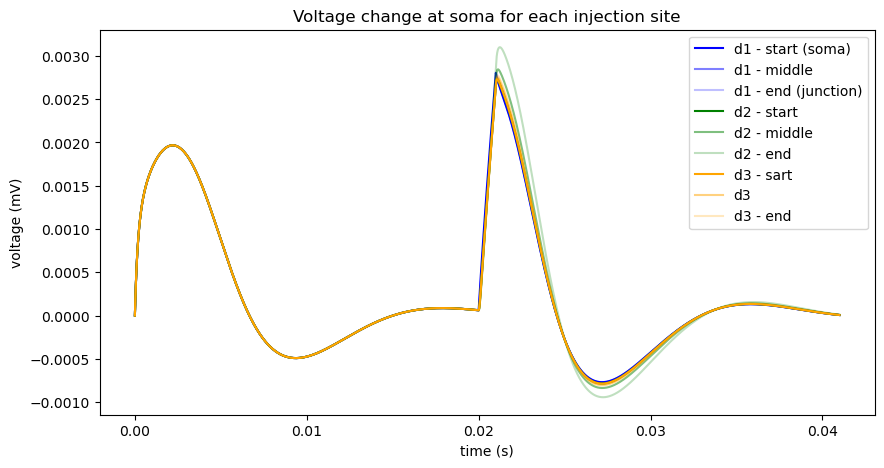

In [ ]:
# plot the change in voltage over time at the soma (v[0]) for each injection site:
# note that voltages have been rescaled so that v_rest = 0:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(v1.t, v1.v[0], color='blue', label='d1 - start (soma)')
ax.plot(v2.t, v2.v[0], color='blue', label='d1 - middle', alpha=0.5)
ax.plot(v3.t, v3.v[0], color='blue', label='d1 - end (junction)', alpha=0.25)

ax.plot(v4.t, v4.v[0], color='green', label='d2 - start')
ax.plot(v5.t, v5.v[0], color='green', label='d2 - middle', alpha=0.5)
ax.plot(v6.t, v6.v[0], color='green', label='d2 - end', alpha=0.25)

ax.plot(v7.t, v7.v[0], color='orange', label='d3 - sart')
ax.plot(v8.t, v8.v[0], color='orange', label='d3', alpha=0.5)
ax.plot(v9.t, v9.v[0], color='orange', label='d3 - end', alpha=0.25)

ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Voltage change at soma for each injection site')
ax.legend()

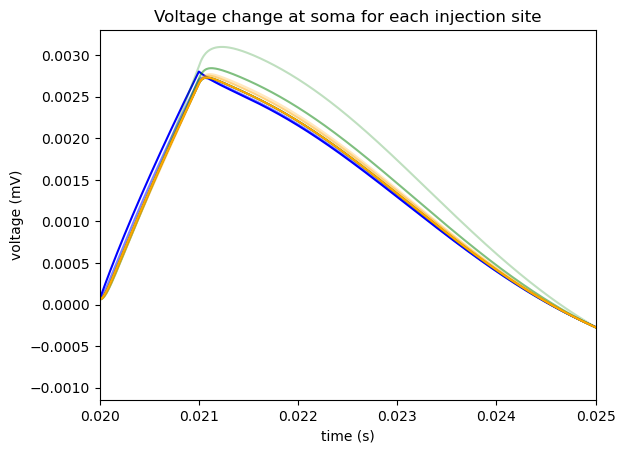

In [ ]:
# show a zoomed-in view of the plot above to show the differences in spike height:
fig, ax = plt.subplots()

ax.plot(v1.t, v1.v[0], color='blue', label='d1 - start (soma)')
ax.plot(v2.t, v2.v[0], color='blue', label='d1 - middle', alpha=0.5)
ax.plot(v3.t, v3.v[0], color='blue', label='d1 - end (junction)', alpha=0.25)

ax.plot(v4.t, v4.v[0], color='green', label='d2 - start')
ax.plot(v5.t, v5.v[0], color='green', label='d2 - middle', alpha=0.5)
ax.plot(v6.t, v6.v[0], color='green', label='d2 - end', alpha=0.25)

ax.plot(v7.t, v7.v[0], color='orange', label='d3 - sart')
ax.plot(v8.t, v8.v[0], color='orange', label='d3', alpha=0.5)
ax.plot(v9.t, v9.v[0], color='orange', label='d3 - end', alpha=0.25)

ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Voltage change at soma for each injection site')
ax.set_xlim([0.02, 0.025])
plt.show()

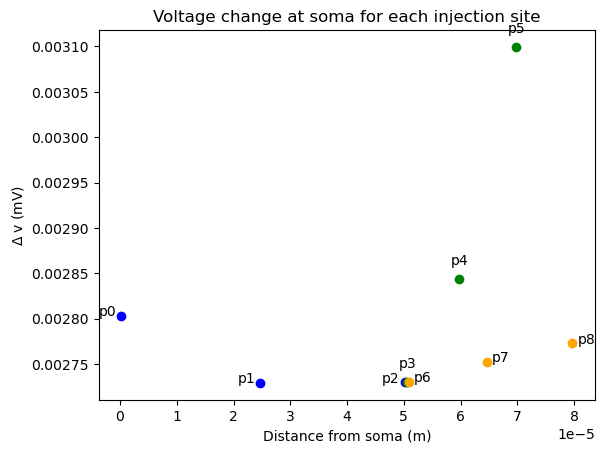

In [ ]:
delta_v = np.zeros((len(locs))) # max voltage change at soma for each injection site
t = np.arange(0, len(delta_v), 1) # x-axis for injection site

# get the max voltage change at the soma for each injection site (v_rest = 0):
delta_v[0] = max(v1.v[0])
delta_v[1] = max(v2.v[0])
delta_v[2] = max(v3.v[0])
delta_v[3] = max(v4.v[0])
delta_v[4] = max(v5.v[0])
delta_v[5] = max(v6.v[0])
delta_v[6] = max(v7.v[0])
delta_v[7] = max(v8.v[0])
delta_v[8] = max(v9.v[0])

# plot the voltage change v_rest - v_max for each injection site:
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(locs[i].distance, delta_v[i], color='blue')
    ax.annotate(('p'+str(i)), (locs[i].distance, delta_v[i]), textcoords='offset points', xytext=(-10,0), ha='center')
for i in range(3, 6):
    ax.scatter(locs[i].distance, delta_v[i], color='green')
    ax.annotate(('p'+str(i)), (locs[i].distance, delta_v[i]), textcoords='offset points', xytext=(0,10), ha='center')
for i in range(6, 9):
    ax.scatter(locs[i].distance, delta_v[i], color='orange')
    ax.annotate(('p'+str(i)), (locs[i].distance, delta_v[i]), textcoords='offset points', xytext=(10,0), ha='center')

ax.set(xlabel='Distance from soma (m)', ylabel='$\Delta$ v (mV)', title='Voltage change at soma for each injection site')
plt.show()

In the plot above, the maximum value of the voltage trace at the soma is plotted for each injection site (along the x-axis). As the distance from the soma increases, the $(\Delta v)$ should decrease (i.e., lower peak). Blue points correspond to injection at points along the major dendrite; green points correspond to d2; and orange points correspond to d3 (with p0 being the closest to the soma).

The blue points (corresponding to d1) show that the action potential reaches a lower maximum as the injection site gets farther from the soma. This makes sense intuitively, since the signal has to travel a larger distance, meaning that it is more likely to experience loss before arriving at the soma (either due to leakage out of the membrane).

In particular, the inejected signal decays exponentially according to the equation: $\Delta V \exp^{-x/\lambda}$ (similar to the diagrams on Slide 12 of Lecture 5). In this equation, x is the distance from the soma, and $\lambda$ is the length constant of the cable, which is a measure of how well-insulated the dendrite is (and also its diameter).

The green points correspond to the first branch (d2) with a diameter of 0.2 um. Here, the attenuation should increase (p3 > p4 > p5), but that's not the case—there seems to be something wrong with my code but I'm not entirely sure what.

In general though, the idea is that the attenuation increases with distance because of the small diameter, which causes the current to encounter higher resistance when propagating down the length of the dendrite (and so the length constant $\lambda$ is shorter). Finally, for the third branch (orange points) with a diameter of 0.5 um, the larger diameter means that the signal can travel with less resistance/attenuation, so the slope should be less steep.

Reference:

[5] E. R. Kandel, J. H. Schwartz, T. M. Jessell, S. A. Siegelbaum, and A. J. Hudspeth, "Membrane Potential and the Passive Electrical Properties of the Neuron," in _Principles of Neural Science, 5th Ed._ New York: McGraw Hill, 2013, ch. 6, pp. 126-147.